# Import from postgres

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .config("spark.jars", "/home/justing/postgresql-42.2.14.jar") \
    .getOrCreate()

observations = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://syntheamass.cj2a2wgkfwhf.us-east-1.rds.amazonaws.com:5432/synthea_mass") \
    .option("dbtable", "observations") \
    .option("user", "postgres") \
    .option("driver", "org.postgresql.Driver") \
    .option("password", "redsox123") \
    .load()

observations.printSchema()



In [4]:
loinc = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://syntheamass.cj2a2wgkfwhf.us-east-1.rds.amazonaws.com:5432/synthea_mass") \
    .option("dbtable", "loinc_num_desc") \
    .option("user", "postgres") \
    .option("driver", "org.postgresql.Driver") \
    .option("password", "redsox123") \
    .load()

loinc.printSchema()

root
 |-- LOINC_NUM: string (nullable = true)
 |-- LONG_COMMON_NAME: string (nullable = true)



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import s3fs
from pyspark.sql.functions import *
from pyspark.sql.types import LongType

In [6]:
K=8 
tabr = loinc

# Format, index, and normalize data

In [8]:
cdf = observations
cdf=cdf.select("CODE","DESCRIPTION").where("CODE != 'CODE'")
cdf=cdf.dropna()
cdf.show(5,truncate=False)

+-------+---------------+
|CODE   |DESCRIPTION    |
+-------+---------------+
|8302-2 |Body Height    |
|8302-2 |Body Height    |
|29463-7|Body Weight    |
|29463-7|Body Weight    |
|39156-5|Body Mass Index|
+-------+---------------+
only showing top 5 rows



In [9]:

from pyspark.ml.feature import StringIndexer
indexer=StringIndexer(inputCol="DESCRIPTION",outputCol="DESCRIPTION_I")
coord=indexer.fit(cdf).transform(cdf)
coord=coord.select("CODE","DESCRIPTION_I")
coord.show(5)

+-------+-------------+
|   CODE|DESCRIPTION_I|
+-------+-------------+
| 8302-2|          0.0|
| 8302-2|          0.0|
|29463-7|          1.0|
|29463-7|          1.0|
|39156-5|          4.0|
+-------+-------------+
only showing top 5 rows



In [10]:
coord=coord.withColumn('CODE',regexp_replace('CODE','-',''))
if coord.dtypes[0][1]!='bigint':
    coord=coord.withColumn('CODE',col('CODE').cast(LongType()))
coord.show(5)


+------+-------------+
|  CODE|DESCRIPTION_I|
+------+-------------+
| 83022|          0.0|
| 83022|          0.0|
|294637|          1.0|
|294637|          1.0|
|391565|          4.0|
+------+-------------+
only showing top 5 rows



In [11]:
vis=coord.toPandas()

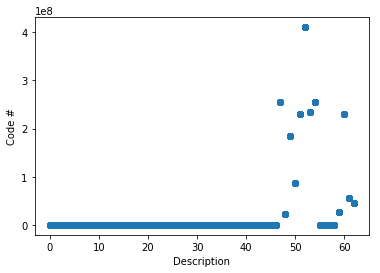

UsageError: Line magic function `%matplot` not found.


In [12]:
plt.scatter(vis['DESCRIPTION_I'],vis['CODE'])
plt.xlabel('Description')
plt.ylabel('Code #')
plt.show()
%matplot plt

# Clustering

## Making feature vectors

In [13]:
from pyspark.ml.feature import VectorAssembler
features = ["CODE","DESCRIPTION_I"]
assembler=VectorAssembler(inputCols=features,outputCol="features")
raw_data=assembler.transform(coord)
raw_data.show(5)

+------+-------------+--------------+
|  CODE|DESCRIPTION_I|      features|
+------+-------------+--------------+
| 83022|          0.0| [83022.0,0.0]|
| 83022|          0.0| [83022.0,0.0]|
|294637|          1.0|[294637.0,1.0]|
|294637|          1.0|[294637.0,1.0]|
|391565|          4.0|[391565.0,4.0]|
+------+-------------+--------------+
only showing top 5 rows



In [14]:
from pyspark.ml.feature import StandardScaler
standardScaler=StandardScaler().setInputCol("features").setOutputCol("scaled_features")
raw_data=standardScaler.fit(raw_data).transform(raw_data)

In [15]:
raw_data.show(5,truncate=False)

+------+-------------+--------------+-----------------------------------------+
|CODE  |DESCRIPTION_I|features      |scaled_features                          |
+------+-------------+--------------+-----------------------------------------+
|83022 |0.0          |[83022.0,0.0] |[0.008154233609368441,0.0]               |
|83022 |0.0          |[83022.0,0.0] |[0.008154233609368441,0.0]               |
|294637|1.0          |[294637.0,1.0]|[0.028938581676706047,0.1347190481983725]|
|294637|1.0          |[294637.0,1.0]|[0.028938581676706047,0.1347190481983725]|
|391565|4.0          |[391565.0,4.0]|[0.03845863124536091,0.53887619279349]   |
+------+-------------+--------------+-----------------------------------------+
only showing top 5 rows



# K-Means

In [16]:
from pyspark.ml.clustering import KMeans
kmeans=KMeans(featuresCol="scaled_features").setK(K)
model=kmeans.fit(raw_data)

In [17]:
predictions = model.transform(raw_data)

In [18]:
clusters=predictions.select("prediction")
clusters.groupby("prediction").agg({'prediction':'count'}).show()

+----------+-----------------+
|prediction|count(prediction)|
+----------+-----------------+
|         1|             8552|
|         6|            72784|
|         3|            63190|
|         5|           790620|
|         4|             2184|
|         7|           610403|
|         2|           646500|
|         0|          3189085|
+----------+-----------------+



# Bisecting K-Means

In [19]:
from pyspark.ml.clustering import BisectingKMeans
bkm=BisectingKMeans(featuresCol="scaled_features").setK(K)
model=bkm.fit(raw_data)

In [20]:
predictions_b=model.transform(raw_data)

In [21]:
cm=predictions_b.select("prediction")
cm.groupby("prediction").agg({'prediction':'count'}).show()

+----------+-----------------+
|prediction|count(prediction)|
+----------+-----------------+
|         1|          1177312|
|         6|             7848|
|         3|           632496|
|         5|           115811|
|         4|          1437374|
|         7|              704|
|         2|           834461|
|         0|          1177312|
+----------+-----------------+



# Gaussian Mixture

In [23]:
from pyspark.ml.clustering import GaussianMixture
gm=GaussianMixture(featuresCol="scaled_features").setK(K)
model=gm.fit(raw_data)

In [24]:
predictions_c=model.transform(raw_data)

In [25]:
cluster2=predictions_c.select("prediction")
cluster2.groupby("prediction").agg({'prediction':'count'}).show()

+----------+-----------------+
|prediction|count(prediction)|
+----------+-----------------+
|         1|           374438|
|         6|          3280929|
|         3|             8552|
|         5|           158124|
|         4|             5443|
|         7|           158124|
|         2|           132715|
|         0|          1264993|
+----------+-----------------+



# Silhouette Score

In [26]:
from pyspark.ml.evaluation import ClusteringEvaluator
eVal=ClusteringEvaluator()
silhouette_k=eVal.evaluate(predictions)
silhouette_h=eVal.evaluate(predictions_b)
silhouette_g=eVal.evaluate(predictions_c)
print(f"""K = {str(K)} \n
K-Means = {str(silhouette_k)} \n
Bisecting K-Means = {str(silhouette_h)} \n
Gaussian Mixture = {str(silhouette_g)} """)

K = 8 

K-Means = -0.3865656739918566 

Bisecting K-Means = -0.19612119851420118 

Gaussian Mixture = 0.5312747691748918 


# Visualization

In [27]:
cdf= cdf.toPandas()
kclust=clusters.toPandas()
hclust=cm.toPandas()
gclust=cluster2.toPandas()

In [28]:
clust=gclust #change *clust to look at different algorithmns
graph=pd.concat([vis,clust],axis=1)
text= pd.concat([cdf,clust],axis=1)
graph.head()

,CODE,DESCRIPTION_I,prediction
0,83022,0.0,6
1,83022,0.0,6
2,294637,1.0,0
3,294637,1.0,0
4,391565,4.0,0


UsageError: Line magic function `%matplot` not found.


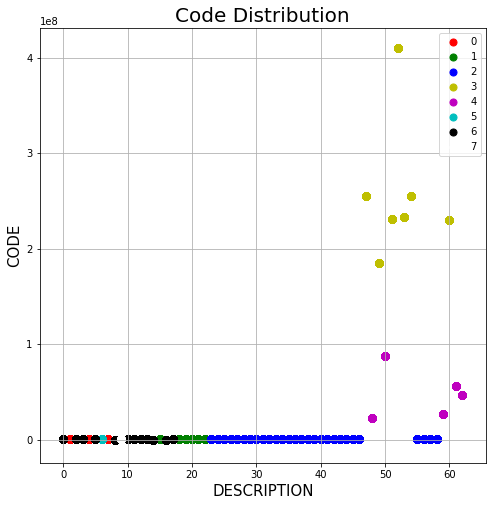

In [29]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('DESCRIPTION', fontsize = 15)
ax.set_ylabel('CODE', fontsize = 15)
ax.set_title('Code Distribution', fontsize = 20)


targets = [0,1,2,3,4,5,6,7,8]
colors = ['r', 'g', 'b','y','m','c','k','w']
for target, color in zip(targets,colors):
    indicesToKeep = graph['prediction'] == target
    ax.scatter(graph.loc[indicesToKeep, 'DESCRIPTION_I']
               , graph.loc[indicesToKeep, 'CODE']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
%matplot plt

# Analysis

In [30]:
group=text
total=coord.count()
g={}
c={}
sg={}
for i in range(K):
    g["group{0}".format(i)]=text[text['prediction']==i]
    c["count{0}".format(i)]=len(g["group{0}".format(i)])
    g["group{0}".format(i)]=spark.createDataFrame(g["group{0}".format(i)]).select("CODE","DESCRIPTION")

In [31]:
alv=0;
r={}
for j in range(K):
    if c["count{0}".format(j)] < (total/K):
        r["risk{0}".format(alv)]=g["group{0}".format(j)]
        alv=alv+1
print("Number of at risk groups: ",alv)

Number of at risk groups:  6


In [32]:
risk = r["risk0"]
for d in range(alv-1):
    risk=risk.union(r["risk{0}".format(d+1)])
risk.count()

837396

In [2]:
tcode="`LOINC_NUM`"
tdesc="`LONG_COMMON_NAME`"

## Match by code

In [34]:
tabr.createOrReplaceTempView("tabr")

risk.createOrReplaceTempView("risk")

ma=spark.sql(f"""
select t.{tcode}, t.{tdesc},
r.DESCRIPTION, r.CODE 
from tabr t 
join risk r
on r.CODE = t.{tcode}
group by 1, 2, 3, 4""")
ma.show(truncate = True)
print("# of Matches: ",ma.count())

+---------+--------------------+--------------------+-------+
|LOINC_NUM|    LONG_COMMON_NAME|         DESCRIPTION|   CODE|
+---------+--------------------+--------------------+-------+
|  33914-3|Glomerular filtra...|Estimated Glomeru...|33914-3|
|   6085-5|Common Ragweed Ig...|Common Ragweed Ig...| 6085-5|
|  66519-0|Percentage area a...|Percentage area a...|66519-0|
|   6206-7|Peanut IgE Ab [Un...|Peanut IgE Ab in ...| 6206-7|
|  66524-0|Percentage area a...|Percentage area a...|66524-0|
|   6082-2|Codfish IgE Ab [U...|Codfish IgE Ab in...| 6082-2|
|   6273-7|Walnut IgE Ab [Un...|Walnut IgE Ab in ...| 6273-7|
|   8331-1|    Oral temperature|    Oral temperature| 8331-1|
|  14959-1|Microalbumin/Crea...|Microalbumin Crea...|14959-1|
|   6075-6|Cladosporium herb...|Cladosporium herb...| 6075-6|
|   6106-9|Egg white IgE Ab ...|Egg white IgE Ab ...| 6106-9|
|  49765-1|Calcium [Mass/vol...|             Calcium|49765-1|
|   6189-5|White Oak IgE Ab ...|White oak IgE Ab ...| 6189-5|
|  71802

## Display codes not in the correct standard

In [35]:
tabr.createOrReplaceTempView("tabr")
risk.createOrReplaceTempView("risk")

spark.sql(f"""
select DISTINCT * 
from risk r
where r.CODE not in (select {tcode} from tabr)""").show()

+---------+--------------------+
|     CODE|         DESCRIPTION|
+---------+--------------------+
|254632001|Small cell carcin...|
|254637007|Non-small cell lu...|
| 26929004|Alzheimer's disea...|
| 22298006|Myocardial Infarc...|
|410429000|      Cardiac Arrest|
|230265002|Familial Alzheime...|
| 55680006|       Drug overdose|
|233604007|           Pneumonia|
| 46177005|End stage renal d...|
|185086009|Chronic obstructi...|
| 87433001|Pulmonary emphyse...|
|230690007|              Stroke|
+---------+--------------------+



## Display observations without codes

In [36]:
risk.createOrReplaceTempView("risk")

spark.sql(""" select * from risk where CODE is null """).show()

+----+-----------+
|CODE|DESCRIPTION|
+----+-----------+
+----+-----------+



# Identify incorrect descriptions

## Compare official Loinc Descriptions with Clinical Descriptions

In [37]:
tabr.createOrReplaceTempView("tabr")
risk.createOrReplaceTempView("risk")

spark.sql(f"""
select t.{tdesc},
r.DESCRIPTION
from tabr t
join risk r
on t.{tcode} = r.CODE
group by 1, 2""").show(truncate = True)

+--------------------+--------------------+
|    LONG_COMMON_NAME|         DESCRIPTION|
+--------------------+--------------------+
|Wheat IgE Ab [Uni...|Wheat IgE Ab in S...|
|Percentage area a...|Percentage area a...|
|Shrimp IgE Ab [Un...|Shrimp IgE Ab in ...|
|Percentage area a...|Percentage area a...|
|Walnut IgE Ab [Un...|Walnut IgE Ab in ...|
|Codfish IgE Ab [U...|Codfish IgE Ab in...|
|Calcium [Mass/vol...|             Calcium|
|Creatinine [Mass/...|          Creatinine|
|Percentage area a...|Percentage area a...|
|History of Hospit...|History of Hospit...|
|      Housing status|      Housing status|
|DXA Radius and Ul...|DXA [T-score] Bon...|
|            FEV1/FVC|           FEV1/​FVC|
|Microalbumin/Crea...|Microalbumin Crea...|
|Egg white IgE Ab ...|Egg white IgE Ab ...|
|American house du...|American house du...|
|Percentage area a...|Percentage area a...|
|Are you covered b...|Are you covered b...|
|Common Ragweed Ig...|Common Ragweed Ig...|
|Cow milk IgE Ab [...|Cow milk I

## Score the similarity of each matched description

In [9]:
from fuzzywuzzy import fuzz
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
tabr.createOrReplaceTempView("tabr")
risk.createOrReplaceTempView("risk")
descriptions = spark.sql(f"""
select t.{tdesc} as ref_description,
r.DESCRIPTION
from tabr t 
join risk r
on t.{tcode} = r.CODE
group by 1, 2""")

ratio = udf(fuzz.ratio)
partial_ratio = udf(fuzz.partial_ratio)
token_sort_ratio = udf(fuzz.token_sort_ratio)
token_set_ratio = udf(fuzz.token_set_ratio)

descriptions = descriptions.withColumn("ratio", 
                                       ratio(descriptions.ref_description, descriptions.DESCRIPTION))

descriptions = descriptions.withColumn("partial_ratio", 
                                       partial_ratio(descriptions.ref_description, descriptions.DESCRIPTION))

descriptions = descriptions.withColumn("token_sort_ratio", 
                                       ratio(descriptions.ref_description, descriptions.DESCRIPTION))

descriptions = descriptions.withColumn("token_set_ratio", 
                                       token_set_ratio(descriptions.ref_description, descriptions.DESCRIPTION))

descriptions.select("ratio", "partial_ratio", "token_sort_ratio", "token_set_ratio").show()

/home/justing/.local/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


+-----+-------------+----------------+---------------+
|ratio|partial_ratio|token_sort_ratio|token_set_ratio|
+-----+-------------+----------------+---------------+
|   74|           67|              74|            100|
|   91|          100|              91|            100|
|   75|           68|              75|            100|
|   93|           98|              93|             94|
|   75|           68|              75|            100|
|   75|           70|              75|            100|
|   38|          100|              38|            100|
|   47|          100|              47|            100|
|   93|           98|              93|             94|
|   89|           98|              89|            100|
|  100|          100|             100|            100|
|   76|           88|              76|            100|
|   94|           88|              94|            100|
|   72|           81|              72|             80|
|   77|           72|              77|            100|
|   84|   

## Display low scores

In [10]:
descriptions.createOrReplaceTempView("descriptions")

dnom=spark.sql("""
select ref_description, DESCRIPTION from descriptions
where token_set_ratio < 70""")
dnom.show(truncate=False)
print("# of Unmatched Descriptions: ",dnom.count())

+-------------------------------------------------------------------+-----------------------------------+
|ref_description                                                    |DESCRIPTION                        |
+-------------------------------------------------------------------+-----------------------------------+
|Cholesterol in LDL [Mass/volume] in Serum or Plasma by Direct assay|Low Density Lipoprotein Cholesterol|
+-------------------------------------------------------------------+-----------------------------------+

# of Unmatched Descriptions:  1
